In [107]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import category_encoders as ce
import re
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
print('files imported')

files imported


In [108]:
x = pd.read_csv('wcR.csv')
x

,IP Address,surveyCompletion,Duration (in seconds),Response ID,Last Name,First Name,Email,Latitude,Longitude,SOC1,...,enrollYear,progress,grade,transferCredits,NumTranCredits,NumCourses,BWS,PPLinPerson,Visit,otherEmail
0,72.94.219.150,100,843,R_11aRu8dfJXw0Fww,Abdulateef,Sana,sxa459@psu.edu,40.351395,-75.930603,Strongly agree,...,2017.0,14.0,Freshman,No,NaN,0,No,0,No,NaN
1,50.251.57.49,100,334,R_3iLqI7NnVRGr8fh,Duntzee,Christopher,CFD5112@PSU.EDU,40.103195,-75.338898,Somewhat agree,...,2014.0,100.0,Senior,Yes,30,20,Yes,10,Yes,cfd5112@psu.edu
2,128.118.199.130,100,601,R_24pXsVrkr4hFC5T,Barnett,Mindy,MAG5188@PSU.EDU,40.784897,-77.847000,Neither agree nor disagree,...,2014.0,96.0,Graduate student,Yes,NaN,20,Yes,NaN,Yes,mag5188@psu.edu
3,72.9.8.222,100,534,R_tWLpyWYLPdczWO5,Alfano,Adrian,ama5044@psu.edu,38.290695,-76.522102,Somewhat agree,...,2017.0,6.0,Freshman,Yes,100,30,Yes,0,Yes,ama5044@psu.edu
4,130.203.175.194,100,617,R_8CAG1g9crinK8Ux,Darrah,Adrienne,axg130@psu.edu,40.807693,-77.861397,Somewhat disagree,...,2016.0,50.0,Graduate student,No,NaN,0,Yes,0,Yes,axg130@psu.edu
5,107.11.81.182,100,624,R_268Xbjz5dcWgg0H,Blodgett,Kevin,kub288@psu.edu,39.955307,-82.071800,Somewhat agree,...,2016.0,24.0,Junior,Yes,120,30,Yes,0,Yes,kub288@psu.edu
6,108.18.217.159,100,668,R_1JFyk26gIPP0XWR,Brooks,Andrew,AMB5012@PSU.EDU,38.817505,-77.630798,Neither agree nor disagree,...,2014.0,90.0,Senior,Yes,60,6,Yes,0,Yes,amb5012@psu.edu
7,66.87.84.176,100,489,R_2s4t3eFelrJNLVp,Bussnick,Luke,LQB5283@PSU.EDU,40.739105,-74.194504,Somewhat agree,...,2014.0,67.0,Junior,Yes,30,10,Yes,0,No,Lqb5283@psu.edu
8,73.79.232.206,100,452,R_4O6VblvXJ4pmT1n,Chen,Emily,EKC5166@PSU.EDU,40.292099,-76.425903,Neither agree nor disagree,...,2016.0,57.0,Sophomore,Yes,20,12,Yes,0,Yes,ekc5166@psu.edu
9,204.76.30.253,100,881,R_3izhtWRgOHlSt96,Baron,Melinda,mjg5978@psu.edu,32.481400,-84.903297,Strongly agree,...,2016.0,50.0,Graduate student,No,NaN,46,No,0,No,mjg5978@psu.edu


In [109]:
x_col = x.columns
#get the non numeric columns
col_non_num = [c for c in x_col if x[c].dtype == 'object']
#drop rows with 5 nan values
x.dropna(thresh=5, inplace=True)

In [110]:
#number of courses, credits are too dirty as many entered text instead of a number
drop_columns = ["surveyCompletion", "Duration (in seconds)", "NumCourses", "transferCredits", "NumTranCredits",
                "WhyProfile", "otherChannels", "otherEmploy", "NonUS", "otherIndusry", "KnownThroughProfile",
                "otherEth", "PPLinPerson", "otherEmail"]
#only drop these columns if they actually exist in the data
drop_columns = [col for col in drop_columns if col in x.columns]
x.drop(columns=drop_columns, inplace=True)
#names of all the soc columns
SOCs = ['SOC'+str(x+1) for x in range(10)]
#names of all the CCE columns
CCEs = ['CCE'+str(x+1) for x in range(24)]
#mapping from each text column to ordinal values
#format is array of dicts containing keys 'col' and 'mapping'
ordinal_cols_mapping = []

In [111]:
#the following are mappings from textual column values to numberical ones
important_scale = [
        ('Extremely important', 7),
        ('Pretty important', 6),
        ('Fairly important', 5),
        ('Moderately important', 4),
        ('Somewhat important', 3),
        ('A little important', 2),
        ('Not at all important', 1)
]

interest_scale = [
    ('Extremely interested', 5),
    ('Rather interested', 4),
    ('Somewhat interested', 3),
    ('A bit of interest', 2),
    ('Not at all interested', 1)
]

Agree_scale = [
        ('Strongly agree', 5),
        ('Somewhat agree', 4),
        ('Neither agree nor disagree', 3),
        ('Somewhat disagree', 2),
        ('Strongly disagree', 1)
]

In [112]:
#fill in the mapping array 
for SOC in SOCs:
    ordinal_cols_mapping.append({
        "col": SOC,
        "mapping": Agree_scale
    })

for CCE in CCEs:
    ordinal_cols_mapping.append({
        "col": CCE,
        "mapping": Agree_scale
    })

for PeerInfo in ["PeerAvail", "PeerProfession", "PeerEdu", "PeerDetails"]:
    ordinal_cols_mapping.append({
        "col": PeerInfo,
        "mapping": important_scale
    })

ordinal_cols_mapping.append({
    "col": "Mconnected",
    "mapping": interest_scale
})



In [113]:
x.columns

Index(['IP Address', 'Response ID', 'Last Name', 'First Name', 'Email',
       'Latitude', 'Longitude', 'SOC1', 'SOC2', 'SOC3', 'SOC4', 'SOC5', 'SOC6',
       'SOC7', 'SOC8', 'SOC9', 'SOC10', 'CCE1', 'CCE2', 'CCE3', 'CCE4', 'CCE5',
       'CCE6', 'CCE7', 'CCE8', 'CCE9', 'CCE10', 'CCE11', 'CCE12', 'CCE13',
       'CCE14', 'CCE15', 'CCE16', 'CCE17', 'CCE18', 'CCE19', 'CCE20', 'CCE21',
       'CCE22', 'CCE23', 'CCE24', 'PeerAvail', 'PeerProfession', 'PeerEdu',
       'PeerDetails', 'OCEnabler', 'Mconnected', 'ProfileComplete', 'age',
       'gender', 'ethnicity', 'InUS', 'Usstate', 'marrital', 'kids',
       'employment', 'indsutry', 'Military', 'ActiveDuty', 'Degree', 'Major',
       'enrollYear', 'progress', 'grade', 'BWS', 'Visit'],
      dtype='object')

In [114]:
#alter data by converting textual columns to numerical
encoder = ce.OrdinalEncoder(mapping=ordinal_cols_mapping, return_df=True)
df = encoder.fit_transform(x)

In [115]:
df

,IP Address,Response ID,Last Name,First Name,Email,Latitude,Longitude,SOC1,SOC2,SOC3,...,indsutry,Military,ActiveDuty,Degree,Major,enrollYear,progress,grade,BWS,Visit
0,72.94.219.150,R_11aRu8dfJXw0Fww,Abdulateef,Sana,sxa459@psu.edu,40.351395,-75.930603,5,5,5,...,NaN,No,NaN,Master degree,Information Sciences and Tech,2017.0,14.0,Freshman,No,No
1,50.251.57.49,R_3iLqI7NnVRGr8fh,Duntzee,Christopher,CFD5112@PSU.EDU,40.103195,-75.338898,4,4,4,...,Other,No,NaN,Undergraduate certificate,Information Sciences and Tech,2014.0,100.0,Senior,Yes,Yes
2,128.118.199.130,R_24pXsVrkr4hFC5T,Barnett,Mindy,MAG5188@PSU.EDU,40.784897,-77.847000,3,3,3,...,Educational services,No,NaN,Master degree,School of Grad Prof Studies,2014.0,96.0,Graduate student,Yes,Yes
3,72.9.8.222,R_tWLpyWYLPdczWO5,Alfano,Adrian,ama5044@psu.edu,38.290695,-76.522102,4,4,4,...,Management of companies or enterprises,No,NaN,Bachelor degree,Liberal Arts,2017.0,6.0,Freshman,Yes,Yes
4,130.203.175.194,R_8CAG1g9crinK8Ux,Darrah,Adrienne,axg130@psu.edu,40.807693,-77.861397,2,3,2,...,Educational services,No,NaN,Master degree,NaN,2016.0,50.0,Graduate student,Yes,Yes
5,107.11.81.182,R_268Xbjz5dcWgg0H,Blodgett,Kevin,kub288@psu.edu,39.955307,-82.071800,4,4,3,...,Mining or energy production,No,NaN,Bachelor degree,Information Sciences and Tech,2016.0,24.0,Junior,Yes,Yes
6,108.18.217.159,R_1JFyk26gIPP0XWR,Brooks,Andrew,AMB5012@PSU.EDU,38.817505,-77.630798,3,3,4,...,Other,No,NaN,Bachelor degree,Liberal Arts,2014.0,90.0,Senior,Yes,Yes
7,66.87.84.176,R_2s4t3eFelrJNLVp,Bussnick,Luke,LQB5283@PSU.EDU,40.739105,-74.194504,4,4,4,...,Manufacturing,No,NaN,Bachelor degree,Business,2014.0,67.0,Junior,Yes,No
8,73.79.232.206,R_4O6VblvXJ4pmT1n,Chen,Emily,EKC5166@PSU.EDU,40.292099,-76.425903,3,3,4,...,Other,No,NaN,Bachelor degree,Business,2016.0,57.0,Sophomore,Yes,Yes
9,204.76.30.253,R_3izhtWRgOHlSt96,Baron,Melinda,mjg5978@psu.edu,32.481400,-84.903297,5,5,5,...,Finance or insurance,No,NaN,Master degree,School of Grad Prof Studies,2016.0,50.0,Graduate student,No,No


In [116]:
#Create new columns by taking the mean of related columns for each row
df['SOC_f'] = df.apply(lambda row: np.mean([row['SOC9'], row['SOC10']]), axis=1)
df['SOC_id'] = df.apply(lambda row: np.mean([row['SOC1'], row['SOC2'], row['SOC3'], row['SOC4'], row['SOC5']]), axis=1)
df['CCE_IR'] = df.apply(lambda row: np.mean([row['CCE13'], row['CCE10'], row['CCE19'], row['CCE9']]), axis=1)
df['CCE_Coor'] = df.apply(lambda row: np.mean([row['CCE24'], row['CCE20'], row['CCE22'], row['CCE21'], row['CCE17']]), axis=1)
df['CCE_SS'] = df.apply(lambda row: np.mean([row['CCE1'], row['CCE2'], row['CCE3'], row['CCE4']]), axis=1)
df.drop(columns=CCEs + SOCs, inplace=True)

In [119]:
df.kids.unique()

array(['0', '1', '2', '3', '4', nan, 'Zero', '3 (2 are twins)', 'none',
       'None', '5', '9'], dtype=object)

In [48]:
#reformat the kids column to only contain numbers or nan
none_i = re.compile(r'none|zero', flags=re.IGNORECASE)
# df.kids = none_i.sub(r'none\i', df.kids)
# replace all 'none' or 'zero' values with 0
df['kids'].replace(none_i, 0, inplace=True)
# extract the number from the kids columns (will be nan if there is no match)
df.kids = df['kids'].str.extract(r'^(\d+)', expand=False)

In [51]:
onehotecoder = ce.OneHotEncoder(cols=["gender", "InUS", "ethnicity", "Usstate", "marrital", "employment"], handle_unknown='impute')
df = onehotecoder.fit_transform(df)

In [60]:
df.drop(columns=col_non_num, inplace=True, axis=1)

KeyError: "['SOC1' 'SOC2' 'SOC3' 'SOC4' 'SOC5' 'SOC6' 'SOC7' 'SOC8' 'SOC9' 'SOC10'\n 'CCE1' 'CCE2' 'CCE3' 'CCE4' 'CCE5' 'CCE6' 'CCE7' 'CCE8' 'CCE9' 'CCE10'\n 'CCE11' 'CCE12' 'CCE13' 'CCE14' 'CCE15' 'CCE16' 'CCE17' 'CCE18' 'CCE19'\n 'CCE20' 'CCE21' 'CCE22' 'CCE23' 'CCE24' 'KnownThroughProfile'\n 'WhyProfile' 'otherChannels' 'gender' 'ethnicity' 'otherEth' 'InUS'\n 'NonUS' 'Usstate' 'marrital' 'employment' 'otherEmploy' 'otherIndusry'\n 'transferCredits' 'NumTranCredits' 'NumCourses' 'PPLinPerson'\n 'otherEmail'] not found in axis"

In [62]:
df_mode, df_mean, df_median = df.mode().iloc[0], df.mean(), df.median()

In [73]:
df = df._get_numeric_data()
df.fillna(df_median, inplace=True)
data = StandardScaler().fit_transform(df.values)
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

In [74]:
cluster.fit_predict(data)
cluster.children_

array([[280, 380],
       [218, 339],
       [342, 363],
       [209, 379],
       [211, 368],
       [357, 370],
       [208, 255],
       [216, 367],
       [196, 202],
       [204, 389],
       [207, 390],
       [212, 391],
       [214, 392],
       [219, 393],
       [348, 394],
       [349, 395],
       [350, 396],
       [354, 397],
       [360, 398],
       [364, 399],
       [365, 400],
       [200, 221],
       [366, 372],
       [215, 383],
       [201, 382],
       [386, 387],
       [197, 203],
       [385, 406],
       [384, 404],
       [205, 358],
       [402, 405],
       [377, 381],
       [371, 388],
       [403, 407],
       [206, 210],
       [373, 409],
       [408, 416],
       [217, 356],
       [359, 415],
       [213, 417],
       [141, 336],
       [355, 419],
       [162, 290],
       [369, 375],
       [103, 302],
       [108, 238],
       [410, 413],
       [414, 427],
       [362, 422],
       [130, 158],
       [352, 429],
       [ 50, 311],
       [ 22,

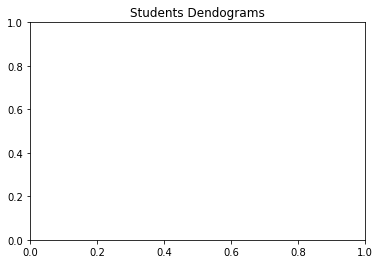

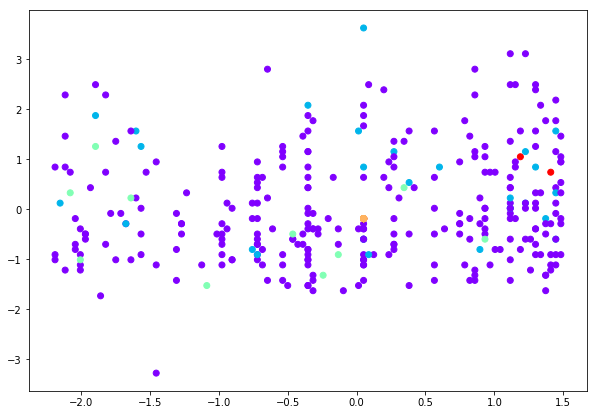

In [83]:
plt.title("Students Dendograms")
plt.figure(figsize=(10, 7))
prog_loc = df.columns.get_loc('progress')
age_loc = df.columns.get_loc('age')
plt.scatter(data[:,prog_loc], data[:,age_loc], c=cluster.labels_, cmap='rainbow') #110 is age, and 112 is progress; 102, 103 is lat and long
plt.show()

In [81]:
df.columns.get_loc('progress')

91